In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

import sys
sys.path.append('../')
from core.networks import BayesianNetwork as BN
from bayes_layer import BayesianConv2D
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

line_markers = ['*','h','<','4','x','d','|','_']
linewidth = 5
markersize = 14

In [2]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [3]:
class BayesianConvNetwork(nn.Module):
    def __init__(self, inputsize, taskcla, init_type = 'random', FC_ratio = 0.5, CNN_ratio = 0.25):
        super().__init__()
        
        ncha,size,_=inputsize
        self.taskcla = taskcla
        
        self.conv1 = BayesianConv2D(ncha,32,kernel_size=3, padding=1, init_type=init_type, ratio = CNN_ratio)
        s = compute_conv_output_size(size,3, padding=1) # 32
        self.conv2 = BayesianConv2D(32,32,kernel_size=3, padding=1, init_type=init_type, ratio = CNN_ratio)
        s = compute_conv_output_size(size,3, padding=1) # 32
        s = s//2 # 16
        self.conv3 = BayesianConv2D(32,64,kernel_size=3, padding=1, init_type=init_type, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 
        self.conv4 = BayesianConv2D(64,64,kernel_size=3, padding=1, init_type=init_type, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 16
        s = s//2 # 8
        self.conv5 = BayesianConv2D(64,128,kernel_size=3, padding=1, init_type=init_type, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv6 = BayesianConv2D(128,128,kernel_size=3, padding=1, init_type=init_type, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        s = s//2 # 4
        self.fc1 = BayesianLinear(s*s*128,256, init_type=init_type, ratio = CNN_ratio)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.MaxPool = torch.nn.MaxPool2d(2)
        
        self.last=torch.nn.ModuleList()
        
        for t,n in self.taskcla:
            self.last.append(torch.nn.Linear(256,n))
        self.relu = torch.nn.ReLU()

    def forward(self, x, sample=False):
        h=self.relu(self.conv1(x,sample))
        h=self.relu(self.conv2(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv3(h,sample))
        h=self.relu(self.conv4(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv5(h,sample))
        h=self.relu(self.conv6(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=h.view(x.shape[0],-1)
        h = self.drop2(self.relu(self.fc1(h,sample)))
        y = []
        for t,i in self.taskcla:
            y.append(self.last[t](h))
        
        return y

In [4]:
def weight_channel_wise_histogram(model_name, ratio = None, std_init = None):
    cnt = 0
    sample_num = []
    taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)]
    task_num = 10
    
#     model = BayesianConvNetwork((3,32,32),taskcla)
    model = BN((1,28,28),taskcla)
    rand_std = []
    for (_, layer) in model.named_children():
        if isinstance(layer, BayesianLinear) == False and isinstance(layer, BayesianConv2D) == False:
            continue
        out_features = layer.weight_rho.shape[0]
        
        sample_num.append(out_features)
        
        std_arr = np.zeros((sample_num[cnt], 11))
        rand_idx = np.arange(out_features)
        np.random.shuffle(rand_idx)
        rand_idx = np.sort(rand_idx[:sample_num[cnt]])
        
        
        if ratio is not None:
            fan_in, fan_out = _calculate_fan_in_and_fan_out(layer.weight_mu)

            if isinstance(layer, BayesianLinear):
                total_var = 2 / fan_in
                std_init = np.sqrt(total_var * ratio)
            if isinstance(layer, BayesianConv2D):
                total_var = 2 / fan_out
                std_init = np.sqrt(total_var * ratio)
        
        std_arr[:,0] = np.ones(sample_num[cnt]) * std_init
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            
            std = np.log(1+np.exp(layer.weight_rho.data.cpu().numpy())).reshape((out_features))
            std = np.sort(std)
            std_arr[:,t+1] = std[rand_idx]
            
        reg_arr = (std_init/std_arr)**2
#         rand_std.append(std_arr)
        rand_std.append(reg_arr)
        cnt += 1
        
    
    plt.figure(figsize=(7,18))
    for l in range(cnt):
#         plt.figure(figsize=(15,5))
#         plt.subplot(3,cnt//2,l+1)
        plt.subplot(1,3,l+1)
        
        for i in range(sample_num[l]):
            plt.plot(np.arange(task_num+1), rand_std[l][i], linestyle = '-')

        fontsize = 20
        plt.xticks(np.arange(task_num+1),fontsize = fontsize)
        plt.yticks(fontsize = 15)

        plt.xlabel('Task', fontsize = fontsize)
        plt.xticks([0,1,2,3,4,5,6,7,8,9,10], fontsize = fontsize)
        if l==0:
#             plt.ylabel('STD',fontsize = fontsize)
            plt.ylabel('Strength',fontsize = fontsize)
        
#         plt.ylim(0,100)
        
        plt.title('Layer %d'%(l+1), fontsize = fontsize)
        plt.tight_layout()

#     plt.savefig('figure/histogram_layer.pdf', bbox_inches='tight')

In [5]:
def avg_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    avg_acc_arr = np.zeros(tasknum)
    for i in range(tasknum):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr

In [6]:
def test_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    return acc_arr

In [7]:
seed_num = 5
UCL_CIFAR = {}
beta_arr = [1e-4]
std_arr = [0.035]
name = 'REBUTTAL_split_cifar100_baye_{}_beta_{:.7f}_std_{:.7f}_unitN_400_batch_256_epoch_100_conv.txt'
for beta in beta_arr:
    UCL_CIFAR[beta] = {}
    for std in std_arr:
        UCL_CIFAR[beta][std] = np.zeros((seed_num,10))
        for i,seed in enumerate([0,1,2,3,5]):
            UCL_CIFAR[beta][std][i] = avg_acc(name.format(seed,beta,std))

In [8]:
UCL_CIFAR_main = {}
beta_arr = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,3e-2]
CNN_ratio_arr = [1/2,1/4,1/8,1/16,1/32,1/64,0.0078120,0.0039060]
name = 'MAIN_split_cifar100_baye_{}_beta_{:.7f}_FC_0.5000000_CNN_{:.7f}_unitN_400_batch_256_epoch_100_conv.txt'
for beta in beta_arr:
    UCL_CIFAR_main[beta] = {}
    for CNN_ratio in CNN_ratio_arr:
        UCL_CIFAR_main[beta][CNN_ratio] = np.zeros((seed_num,10))
        for seed in range(1):
            UCL_CIFAR_main[beta][CNN_ratio][seed] = avg_acc(name.format(seed,beta,CNN_ratio))

In [9]:
EWC_CIFAR = {}
lamb_arr = [7000]
name = 'REBUTTAL_split_cifar100_ewc_with_log_{}_lamb_{:.1f}_unitN_400_batch_256_epoch_100_conv.txt'
for lamb in lamb_arr:
    EWC_CIFAR[lamb] = np.zeros((seed_num,10))
    for i,seed in enumerate([0,1,2,3,5]):
        EWC_CIFAR[lamb][i] = avg_acc(name.format(seed,lamb))

In [10]:
SI_CIFAR = {}
c_arr = [1.0]
name = 'REBUTTAL_split_cifar100_si_with_log_{}_c_{}_unitN_400_batch_256_epoch_100_conv.txt'
for c in c_arr:
    SI_CIFAR[c] = np.zeros((seed_num,10))
    for i,seed in enumerate([0,1,2,3,5]):
        SI_CIFAR[c][i] = avg_acc(name.format(seed,c))

[0.6958     0.6439     0.6158     0.61375    0.61392    0.60643333
 0.60302857 0.608975   0.606      0.60724   ]
[0.7058     0.662      0.63346667 0.62755    0.63356    0.61463333
 0.61128571 0.615225   0.62275556 0.61608   ]


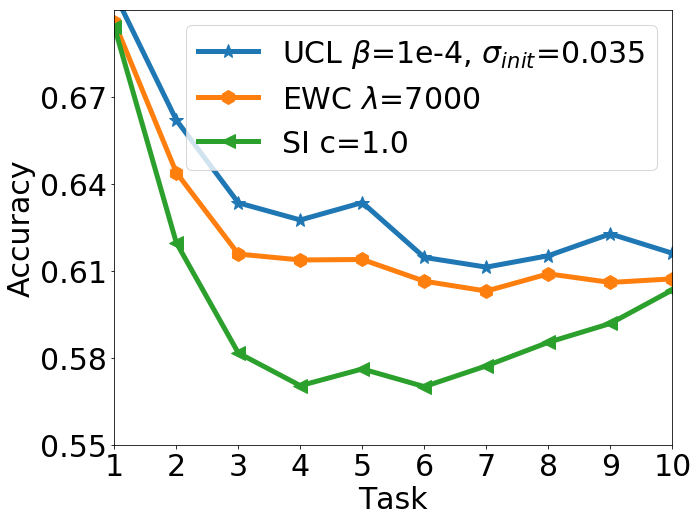

In [11]:
task = np.arange(10) + 1

# plt.errorbar(task, np.mean(SI_CIFAR[1.0], axis = 0), np.std(SI_CIFAR[1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.errorbar(task, np.mean(EWC_CIFAR[7000], axis = 0), np.std(EWC_CIFAR[7000], axis = 0), linestyle='-', label='EWC lamb=7000')
# plt.errorbar(task, np.mean(UCL_CIFAR[1e-4][0.035], axis = 0), np.std(UCL_CIFAR[1e-4][0.035], axis = 0), linestyle='-', label='UCL beta=1e-4 std=0.035')

plt.figure(figsize=(10,8))
plt.plot(task, np.mean(UCL_CIFAR[1e-4][0.035], axis = 0), linestyle = '-', label=r'UCL $\beta$=1e-4, $\sigma_{init}$=0.035', marker = line_markers[0], linewidth=linewidth, markersize=markersize)
plt.plot(task, np.mean(EWC_CIFAR[7000], axis = 0), linestyle = '-', label=r'EWC $\lambda$=7000', marker = line_markers[1], linewidth=linewidth, markersize=markersize)
plt.plot(task, np.mean(SI_CIFAR[1.0], axis = 0), linestyle = '-', label=r'SI c=1.0', marker = line_markers[2], linewidth=linewidth, markersize=markersize)


# plt.plot(task, SI_CIFAR[1.0][0], linestyle='-', label='SI c=1.0')
# plt.plot(task, EWC_CIFAR[7000][0], linestyle='-', label='EWC lamb=7000')
# plt.plot(task, UCL_CIFAR[1e-4][0.035][0], linestyle='-', label='UCL beta=1e-4 std=0.035')
# plt.plot(task, UCL_CIFAR_main[5e-5][1/8][0], linestyle='-', label='UCL_main beta=5e-5 ratio=1/8')

plt.xlabel('Task', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.xlim(1,10)
plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = 30)
plt.ylim(0.55,0.70)
plt.yticks([0.55,0.58,0.61,0.64,0.67], fontsize = 30)

# plt.title('Split CIFAR-100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize = 30)

print(np.mean(EWC_CIFAR[7000], axis = 0))
print(np.mean(UCL_CIFAR[1e-4][0.035], axis = 0))

plt.savefig('figure/CIFAR_100.pdf', bbox_inches='tight')

In [12]:

# task = np.arange(10) + 1

# for i in range(4):
#     plt.figure()
# #     plt.plot(task, EWC_CIFAR[7000][i], linestyle = '-', label='EWC c=7000 seed=%d'%i)
# #     plt.plot(task, SI_CIFAR[1.0][i], linestyle = '-', label='SI c=1.0 seed=%d'%i)
#     plt.plot(task, UCL_CIFAR[1e-4][0.035][i], linestyle='-', label='UCL beta=1e-4 std=0.035 seed=%d'%i)
    
#     plt.xticks([1,2,3,4,5,6,7,8,9,10],fontsize = 20)

#     plt.xlabel('Task', fontsize=20)
#     plt.ylabel('Accuracy', fontsize=20)
#     plt.ylim(0.5,0.8)
#     plt.yticks([0.50,0.55,0.60,0.65,0.70,0.75,0.80], fontsize = 20)
#     plt.title('CIFAR 100', fontsize = 20)
#     plt.legend(loc = 'lower left')


In [13]:
seed_num = 1
UCL_Imagenet_100 = {}
beta_arr = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,3e-2]
std_arr = [0.01,0.015,0.02,0.025,0.03,0.035]
name = 'REBUTTAL_split_mini_imagenet_baye_{}_beta_{:.7f}_std_{:.7f}_unitN_400_batch_256_epoch_100_conv.txt'
for beta in beta_arr:
    UCL_Imagenet_100[beta] = {}
    for std in std_arr:
        UCL_Imagenet_100[beta][std] = np.zeros((seed_num,10))
        for seed in range(seed_num):
            UCL_Imagenet_100[beta][std][seed] = avg_acc(name.format(seed,beta,std))

In [14]:
UCL_Imagenet_50 = {}
beta_arr = [1e-5,5e-5,1e-4]
std_arr = [0.003,0.005,0.007,0.009]
name = 'REBUTTAL_split_mini_imagenet_baye_{}_beta_{:.7f}_std_{:.7f}_unitN_400_batch_256_epoch_50_conv.txt'
for beta in beta_arr:
    UCL_Imagenet_50[beta] = {}
    for std in std_arr:
        UCL_Imagenet_50[beta][std] = np.zeros((seed_num,10))
        for seed in range(seed_num):
            UCL_Imagenet_50[beta][std][seed] = avg_acc(name.format(seed,beta,std))

In [15]:
EWC_Imagenet = {}
lamb_arr = [10,30,50,70,90,100,300,500,700,900,1000,3000,5000,7000,9000,10000,30000,50000,70000,90000]
name = 'REBUTTAL_split_mini_imagenet_ewc_with_log_{}_lamb_{:.1f}_unitN_400_batch_256_epoch_100_conv.txt'
for lamb in lamb_arr:
    EWC_Imagenet[lamb] = np.zeros((seed_num,10))
    for seed in range(seed_num):
        EWC_Imagenet[lamb][seed] = avg_acc(name.format(seed,lamb))

In [16]:
SI_Imagenet = {}
c_arr = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
name = 'REBUTTAL_split_mini_imagenet_si_with_log_{}_c_{}_unitN_400_batch_256_epoch_100_conv.txt'
for c in c_arr:
    SI_Imagenet[c] = np.zeros((seed_num,10))
    for seed in range(seed_num):
        SI_Imagenet[c][seed] = avg_acc(name.format(seed,c))

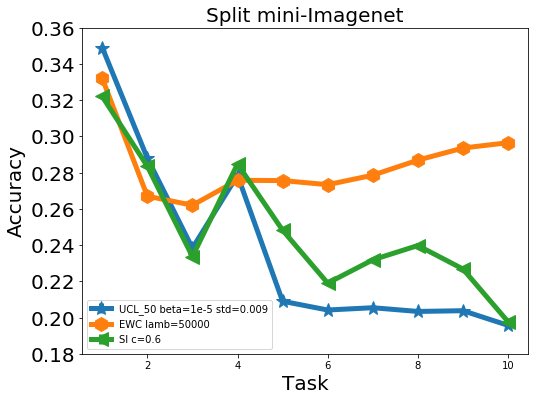

In [17]:
task = np.arange(10) + 1

plt.figure(figsize=(8,6))
plt.errorbar(task, np.mean(UCL_Imagenet_50[1e-5][0.009], axis = 0), np.std(UCL_Imagenet_50[1e-5][0.009], axis = 0), linestyle='-', label='UCL_50 beta=1e-5 std=0.009', marker = line_markers[0], linewidth=linewidth, markersize=markersize)
plt.errorbar(task, np.mean(EWC_Imagenet[50000], axis = 0), np.std(EWC_Imagenet[50000], axis = 0), linestyle='-', label='EWC lamb=50000', marker = line_markers[1], linewidth=linewidth, markersize=markersize)
plt.errorbar(task, np.mean(SI_Imagenet[0.6], axis = 0), np.std(SI_Imagenet[0.6], axis = 0), linestyle='-', label='SI c=0.6', marker = line_markers[2], linewidth=linewidth, markersize=markersize)



plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim(0.18,0.36)
plt.yticks([0.18,0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36], fontsize = 20)
plt.title('Split mini-Imagenet', fontsize = 20)
plt.legend(loc = 'lower left')




In [18]:
seed_num = 3
UCL_Omniglot = {}
beta_arr = [3e-2]
std_arr = [0.03,0.035]
name = 'REBUTTAL_split_omniglot_baye_{}_beta_{:.7f}_std_{:.7f}_unitN_400_batch_128_epoch_100_conv.txt'
for beta in beta_arr:
    UCL_Omniglot[beta] = {}
    for std in std_arr:
        UCL_Omniglot[beta][std] = np.zeros((seed_num,10))
#         for seed in range(seed_num):
        for i,seed in enumerate([2,3,5]):
            UCL_Omniglot[beta][std][i] = avg_acc(name.format(seed,beta,std))

In [19]:
EWC_Omniglot = {}
lamb_arr = [90000]
name = 'REBUTTAL_split_omniglot_ewc_with_log_{}_lamb_{:.1f}_unitN_400_batch_128_epoch_100_conv.txt'
for lamb in lamb_arr:
    EWC_Omniglot[lamb] = np.zeros((seed_num,10))
#     for seed in range(seed_num):
    for i,seed in enumerate([2,3,5]):
        EWC_Omniglot[lamb][i] = avg_acc(name.format(seed,lamb))

In [20]:
SI_Omniglot = {}
c_arr = [1.0]
name = 'REBUTTAL_split_omniglot_si_with_log_{}_c_{}_unitN_400_batch_128_epoch_100_conv.txt'
for c in c_arr:
    SI_Omniglot[c] = np.zeros((seed_num,10))
#     for seed in range(seed_num):
    for i,seed in enumerate([2,3,5]):
        SI_Omniglot[c][i] = avg_acc(name.format(seed,c))

[0.7226     0.77035    0.76983333 0.627375   0.68826    0.71883333
 0.73065714 0.7456375  0.77144444 0.78905   ]


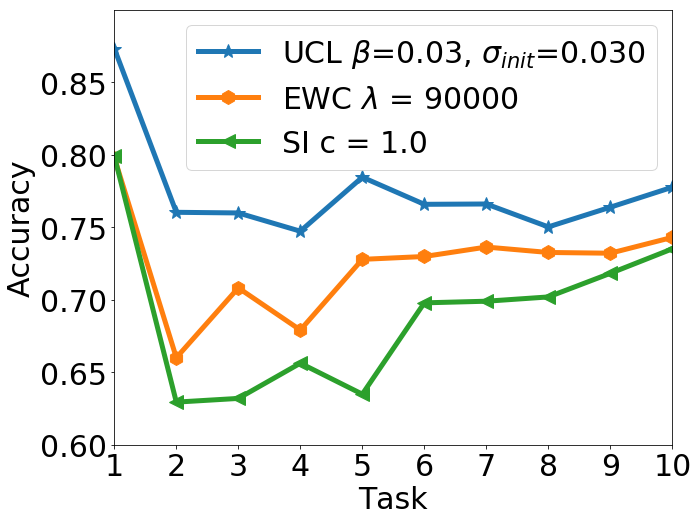

In [21]:
task = np.arange(10) + 1
plt.figure(figsize=(10,8))

# plt.plot(task, np.mean(UCL_Omniglot[3e-2][0.035], axis=0), linestyle = '-', label = r'UCL $\beta$=0.03, $\sigma_{init}$=0.035', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, np.mean(UCL_Omniglot[3e-2][0.030], axis=0), linestyle = '-', label = r'UCL $\beta$=0.03, $\sigma_{init}$=0.030', marker = line_markers[0], linewidth=linewidth, markersize=markersize)
plt.plot(task, np.mean(EWC_Omniglot[90000], axis=0), linestyle = '-', label = r'EWC $\lambda$ = 90000', marker = line_markers[1], linewidth=linewidth, markersize=markersize)
plt.plot(task, np.mean(SI_Omniglot[1.0], axis=0), linestyle = '-', label = r'SI c = 1.0', marker = line_markers[2], linewidth=linewidth, markersize=markersize)


plt.xlabel('Task', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.xlim(1,10)
plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = 30)
plt.ylim(0.60,0.9)
plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85], fontsize = 30)
# plt.title('Omniglot', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=30)

print(EWC_Omniglot[90000][0])

plt.savefig('figure/Omniglot.pdf', bbox_inches='tight')

[0.7226     0.77035    0.76983333 0.627375   0.68826    0.71883333
 0.73065714 0.7456375  0.77144444 0.78905   ]
[0.7195     0.7246     0.7427     0.776475   0.81106    0.79426667
 0.81425714 0.7579875  0.73012222 0.75484   ]
[0.9523     0.4853     0.61226667 0.633675   0.68446    0.6766
 0.66431429 0.6944125  0.69492222 0.68539   ]


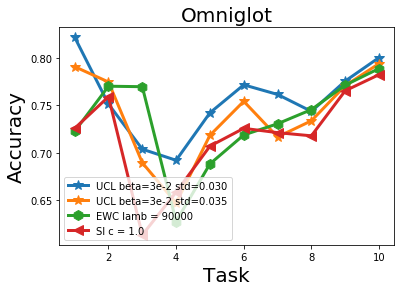

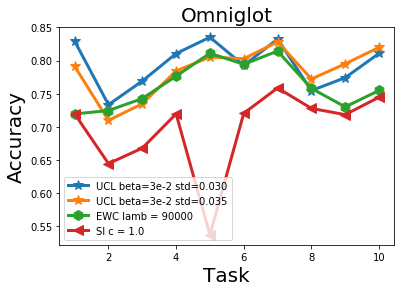

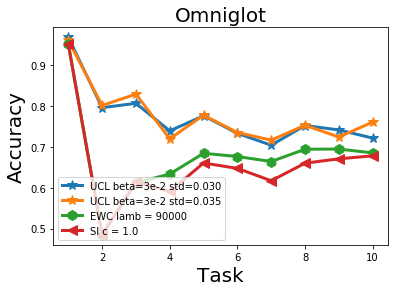

In [22]:
task = np.arange(10) + 1
# plt.figure(figsize=(8,6))

for i in range(seed_num):
    plt.figure()
    plt.plot(task, UCL_Omniglot[3e-2][0.030][i], linestyle = '-', label = 'UCL beta=3e-2 std=0.030', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task, UCL_Omniglot[3e-2][0.035][i], linestyle = '-', label = 'UCL beta=3e-2 std=0.035', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task, EWC_Omniglot[90000][i], linestyle = '-', label = 'EWC lamb = 90000', marker = line_markers[1], linewidth=3, markersize=10)
    plt.plot(task, SI_Omniglot[1.0][i], linestyle = '-', label = 'SI c = 1.0', marker = line_markers[2], linewidth=3, markersize=10)


    plt.xlabel('Task', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
#     plt.ylim(0.555,0.9)
#     plt.yticks([0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90], fontsize = 20)
    plt.title('Omniglot', fontsize = 20)
    plt.legend(loc = 'lower left')
    print(EWC_Omniglot[90000][i])

In [23]:
seed_num = 8
UCL_CIFAR10 = {}
beta_arr = [1e-3]
std_arr = [0.025,]
name = 'REBUTTAL_split_cifar10_baye_{}_beta_{:.7f}_std_{:.7f}_unitN_400_batch_256_epoch_100_conv.txt'
for beta in beta_arr:
    UCL_CIFAR10[beta] = {}
    for std in std_arr:
        UCL_CIFAR10[beta][std] = np.zeros((seed_num,5))
        for seed in range(seed_num):
#         for i,seed in enumerate([2,3,5]):
            UCL_CIFAR10[beta][std][seed] = avg_acc(name.format(seed,beta,std), tasknum=5)

In [24]:
EWC_CIFAR10 = {}
lamb_arr = [7000]
name = 'REBUTTAL_split_cifar10_ewc_with_log_{}_lamb_{:.1f}_unitN_400_batch_256_epoch_100_conv.txt'
for lamb in lamb_arr:
    EWC_CIFAR10[lamb] = np.zeros((seed_num,5))
    for seed in range(seed_num):
#     for i,seed in enumerate([2,3,5]):
        EWC_CIFAR10[lamb][seed] = avg_acc(name.format(seed,lamb), tasknum=5)

In [25]:
SI_CIFAR10 = {}
c_arr = [0.8]
name = 'REBUTTAL_split_cifar10_si_with_log_{}_c_{}_unitN_400_batch_256_epoch_100_conv.txt'
for c in c_arr:
    SI_CIFAR10[c] = np.zeros((seed_num,5))
    for seed in range(seed_num):
#     for i,seed in enumerate([2,3,5]):
        SI_CIFAR10[c][seed] = avg_acc(name.format(seed,c), tasknum=5)

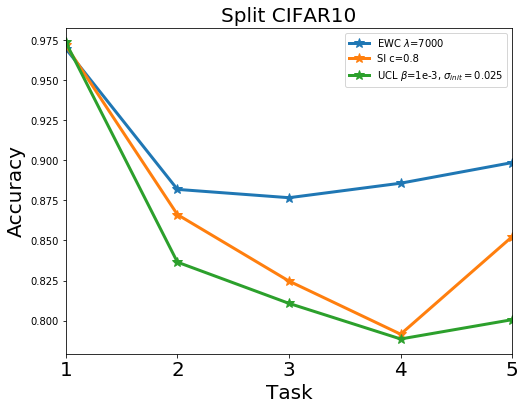

In [26]:
task = np.arange(5) + 1
plt.figure(figsize=(8,6))


# plt.plot(task, EWC_CIFAR10[7000][0], linestyle = '-', label = r'EWC $\lambda$=7000', marker = line_markers[0], linewidth=3, markersize=10)
# plt.plot(task, SI_CIFAR10[0.8][0], linestyle = '-', label = 'SI c=0.8', marker = line_markers[0], linewidth=3, markersize=10)
# plt.plot(task, UCL_CIFAR10[1e-3][0.025][0], linestyle = '-', label = r'UCL $\beta$=1e-3, $\sigma_{init}=0.025$', marker = line_markers[0], linewidth=3, markersize=10)

plt.plot(task, np.mean(EWC_CIFAR10[7000], axis = 0), linestyle = '-', label = r'EWC $\lambda$=7000', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, np.mean(SI_CIFAR10[0.8], axis = 0), linestyle = '-', label = 'SI c=0.8', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, np.mean(UCL_CIFAR10[1e-3][0.025], axis = 0), linestyle = '-', label = r'UCL $\beta$=1e-3, $\sigma_{init}=0.025$', marker = line_markers[0], linewidth=3, markersize=10)





plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlim(1,5)
plt.xticks([1,2,3,4,5], fontsize = 20)
# plt.ylim(0.60,0.85)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85], fontsize = 20)
plt.title('Split CIFAR10', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=10)


<Figure size 576x432 with 0 Axes>

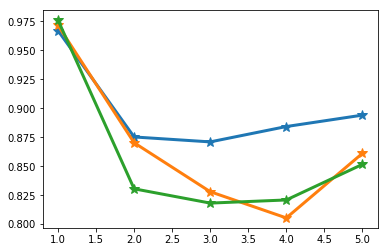

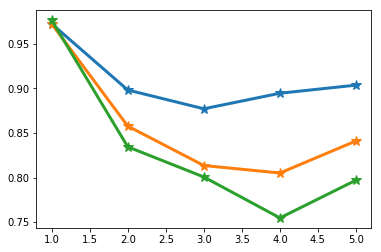

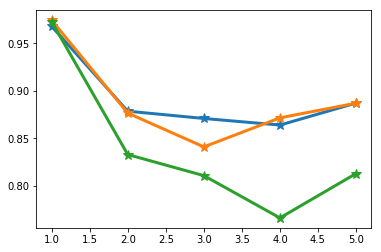

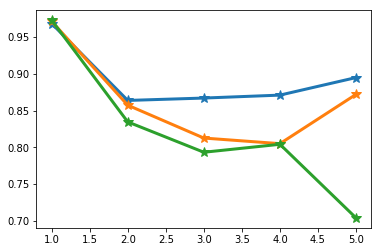

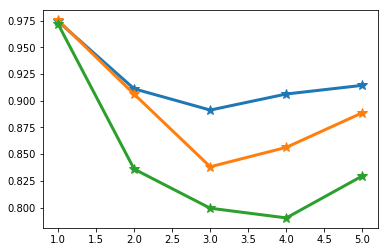

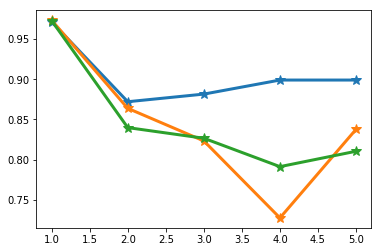

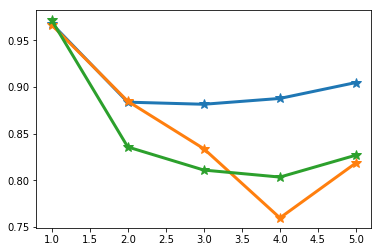

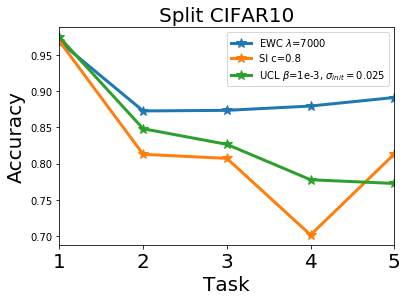

In [27]:
task = np.arange(5) + 1
plt.figure(figsize=(8,6))

for i in range(seed_num):
    plt.figure()
    plt.plot(task, EWC_CIFAR10[7000][i], linestyle = '-', label = r'EWC $\lambda$=7000', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task, SI_CIFAR10[0.8][i], linestyle = '-', label = 'SI c=0.8', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task, UCL_CIFAR10[1e-3][0.025][i], linestyle = '-', label = r'UCL $\beta$=1e-3, $\sigma_{init}=0.025$', marker = line_markers[0], linewidth=3, markersize=10)






plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlim(1,5)
plt.xticks([1,2,3,4,5], fontsize = 20)
# plt.ylim(0.60,0.85)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85], fontsize = 20)
plt.title('Split CIFAR10', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=10)



In [28]:
seed_num = 1
UCL_test = {}
epoch_arr = [25,50,75,100]
batch_arr = [32,64,128,256]
name = 'REBUTTAL_split_omniglot_baye_{}_beta_0.0300000_std_0.0350000_unitN_400_batch_{}_epoch_{}_conv.txt'
for epoch in epoch_arr:
    UCL_test[epoch] = {}
    for batch in batch_arr:
        UCL_test[epoch][batch] = np.zeros((seed_num,10))
        for seed in range(seed_num):
            UCL_test[epoch][batch][seed] = avg_acc(name.format(seed,batch,epoch))

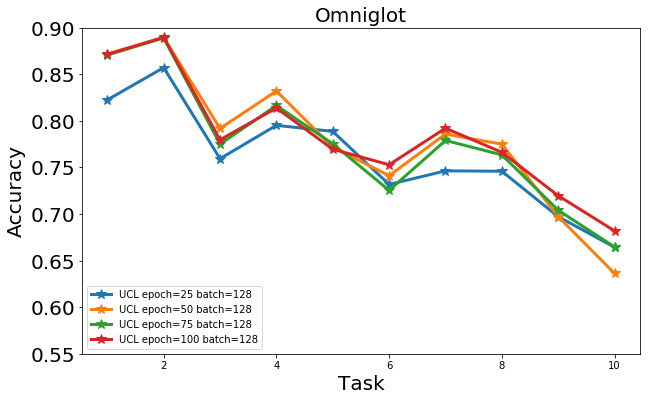

In [29]:
task = np.arange(10) + 1
plt.figure(figsize=(10,6))

plt.plot(task, UCL_test[25][128][0], linestyle = '-', label = 'UCL epoch=25 batch=128', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, UCL_test[50][128][0], linestyle = '-', label = 'UCL epoch=50 batch=128', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, UCL_test[75][128][0], linestyle = '-', label = 'UCL epoch=75 batch=128', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, UCL_test[100][128][0], linestyle = '-', label = 'UCL epoch=100 batch=128', marker = line_markers[0], linewidth=3, markersize=10)
plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim(0.555,0.9)
plt.yticks([0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90], fontsize = 20)
plt.title('Omniglot', fontsize = 20)
plt.legend(loc = 'lower left')


In [30]:
# sns.set_palette(sns.color_palette("husl", 100))

In [31]:
# name = '../models/trained_model/MAIN_split_cifar100_baye_0_beta_0.0000100_FC_0.5000000_CNN_0.0039060_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=0.0039060)

In [32]:
# name = '../models/trained_model/MAIN_split_cifar100_baye_0_beta_0.0000100_FC_0.5000000_CNN_0.0312500_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=0.0312500)

In [33]:
# name = '../models/trained_model/MAIN_split_cifar100_baye_0_beta_0.0050000_FC_0.5000000_CNN_0.0312500_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=0.0312500)

In [34]:
# name = '../models/trained_model/MAIN_split_cifar100_baye_0_beta_0.0050000_FC_0.5000000_CNN_0.0625000_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=0.0625000)

In [35]:
# name = '../models/trained_model/MAIN_split_cifar100_baye_0_beta_0.0050000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=0.1250000)

In [36]:
# name = '../models/trained_model/REBUTTAL_split_cifar100_baye_0_beta_0.0000100_std_0.0350000_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, std_init = 0.035)

In [37]:
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0200000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=0.5)